# Python/Kerasで深層学習：MNISTをRNNで学習

RNN --> 階層的LSTM

https://github.com/keras-team/keras/blob/master/examples/mnist_hierarchical_rnn.py

In the below MNIST example the first LSTM layer first encodes every
column of pixels of shape (28, 1) to a column vector of shape (128,).
The second LSTM layer encodes then these 28 column vectors of shape (28, 128)
to a image vector representing the whole image.
A final Dense layer is added for prediction.

"""Example of using Hierarchical RNN (HRNN) to classify MNIST digits.

HRNNs can learn across multiple levels
of temporal hierarchy over a complex sequence.
Usually, the first recurrent layer of an HRNN
encodes a sentence (e.g. of word vectors)
into a  sentence vector.
The second recurrent layer then encodes a sequence of
such vectors (encoded by the first layer) into a document vector.
This document vector is considered to preserve both
the word-level and sentence-level structure of the context.

# References

- [A Hierarchical Neural Autoencoder for Paragraphs and Documents]
(https://arxiv.org/abs/1506.01057)
    Encodes paragraphs and documents with HRNN.
    Results have shown that HRNN outperforms standard
    RNNs and may play some role in more sophisticated generation tasks like
    summarization or question answering.
- [Hierarchical recurrent neural network for skeleton based action recognition]
(http://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=7298714)
    Achieved state-of-the-art results on
    skeleton based action recognition with 3 levels
    of bidirectional HRNN combined with fully connected layers.

In the below MNIST example the first LSTM layer first encodes every
column of pixels of shape (28, 1) to a column vector of shape (128,).
The second LSTM layer encodes then these 28 column vectors of shape (28, 128)
to a image vector representing the whole image.
A final Dense layer is added for prediction.

After 5 epochs: train acc: 0.9858, val acc: 0.9864
"""

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3  
session = tf.Session(config=config)
import keras
from keras import backend as K
K.set_session(session) 

Using TensorFlow backend.


In [2]:
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Dense, TimeDistributed
from keras.layers import LSTM, CuDNNLSTM

num_classes = 10 # クラス数

# Embedding dimensions.
row_hidden = 128
col_hidden = 128

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Reshapes data to 4D for Hierarchical RNN.
# Reshapes data to 4D for Hierarchical RNN.
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

# Converts class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(x_train.shape[0], '訓練データ数')
print(x_test.shape[0], 'テストデータ数')


60000 訓練データ数
10000 テストデータ数


In [3]:

row, col, pixel = x_train.shape[1:]

# 4D input.
x = Input(shape=(row, col, pixel))

# Encodes a row of pixels using TimeDistributed Wrapper.
encoded_rows = TimeDistributed(CuDNNLSTM(row_hidden))(x)

# Encodes columns of encoded rows.
encoded_columns = CuDNNLSTM(col_hidden)(encoded_rows)

# Final predictions and model.
prediction = Dense(num_classes, activation='softmax')(encoded_columns)
model = Model(x, prediction)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.summary()


Instructions for updating:
Use the retry module or similar alternatives.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 28, 128)           67072     
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 128)               132096    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 200,458
Trainable params: 200,458
Non-trainable params: 0
_________________________________________________________________


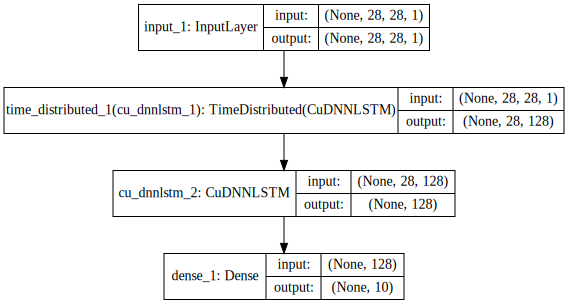

In [4]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, to_file='PYTHON-MNIST-RNN.jpg')

SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))


In [5]:
batch_size = 32 # バッチサイズ
epochs = 10 # エポック

# Training.
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))


Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 22s 372us/step - loss: 0.4653 - acc: 0.8449 - val_loss: 0.1021 - val_acc: 0.9663
Epoch 2/10
60000/60000 [==============================] - 20s 340us/step - loss: 0.1149 - acc: 0.9648 - val_loss: 0.0729 - val_acc: 0.9760
Epoch 3/10
60000/60000 [==============================] - 20s 341us/step - loss: 0.0772 - acc: 0.9767 - val_loss: 0.0645 - val_acc: 0.9800
Epoch 4/10
60000/60000 [==============================] - 21s 344us/step - loss: 0.0603 - acc: 0.9821 - val_loss: 0.0728 - val_acc: 0.9780
Epoch 5/10
60000/60000 [==============================] - 20s 338us/step - loss: 0.0499 - acc: 0.9850 - val_loss: 0.0483 - val_acc: 0.9848
Epoch 6/10
60000/60000 [==============================] - 20s 339us/step - loss: 0.0424 - acc: 0.9870 - val_loss: 0.0475 - val_acc: 0.9876
Epoch 7/10
60000/60000 [==============================] - 20s 335us/step - loss: 0.0383 - acc: 0.9879 - val_loss: 0.

In [6]:
# HDF5ファイルでモデル全体とモデルの重みを保存
model.save("PYTHON-MNIST-RNN.h5")
model.save_weights("PYTHON-MNIST-RNN-weights.h5")

In [7]:
# pickleで訓練のヒストリーを保存
import pickle
with open('PYTHON-MNIST-RNN.pkl', 'wb') as h_file:
    pickle.dump(history.history, h_file)

In [8]:
pred = model.predict(x_test)

# 結果を表示
print("予測:\n", pred)

予測:
 [[1.5553193e-06 4.7167737e-07 1.0810339e-06 ... 9.9992001e-01
  1.8817829e-07 5.8312409e-05]
 [8.4760341e-06 5.3721701e-06 9.9997008e-01 ... 3.0984286e-06
  9.8895066e-07 2.0818406e-07]
 [1.5413877e-07 9.9998844e-01 1.7174298e-07 ... 6.6232274e-06
  1.9479551e-06 3.6142265e-07]
 ...
 [2.7122417e-07 1.3555848e-07 1.8979875e-07 ... 2.3837721e-07
  2.7288636e-06 3.4251614e-06]
 [2.9282121e-06 1.4091811e-06 4.8386746e-06 ... 2.5097520e-06
  1.4673290e-04 1.9034226e-06]
 [1.3847089e-05 5.0066461e-07 2.7934284e-06 ... 5.4552208e-07
  5.9246423e-07 1.2761153e-06]]


In [9]:
score = model.evaluate(x_test, y_test, verbose=0)
print('テストデータの損失:', score[0])
print('テストデータの精度:', score[1])

テストデータの損失: 0.046859635134600106
テストデータの精度: 0.9877


In [10]:
# Matplotlibのフォントの制御（大きさや種類）
%matplotlib inline
import numpy as np # Numpy
import matplotlib
import matplotlib.pyplot as plt # 描画ライブラリ
print (matplotlib.rcParams.get('font.family'))
import matplotlib.font_manager as fm
import matplotlib.patheffects as path_effects

font_prop = fm.FontProperties()  
font_prop.set_style('normal')
font_prop.set_weight('light')
font_prop.set_size('12')

fp2 = font_prop.copy()# フォントプロパティ(FP)をコピー
fp2.set_size('20')# フォントプロパティ(FP)をコピー
fp2.set_family('serif')# フォントはSerif(明朝体など）に設定

['sans-serif']


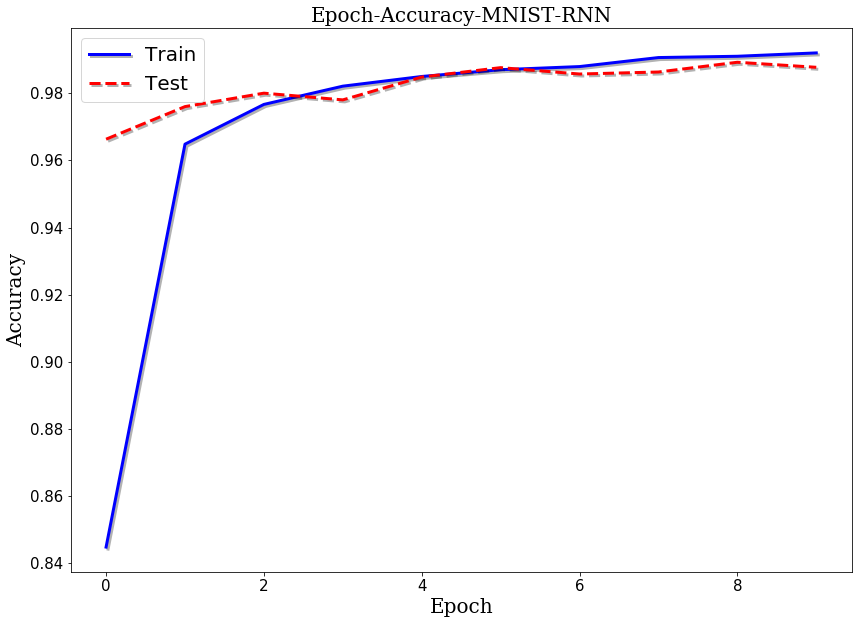

In [11]:
% matplotlib inline
import matplotlib.pyplot as plt

# 精度グラフの描画　% matplotlib inline
plt.figure(figsize=(14,10))

plt.plot(history.history['acc'], 
         color='b', 
         linestyle='-', 
         linewidth=3, 
         path_effects=[path_effects.SimpleLineShadow(),
                       path_effects.Normal()])
plt.plot(history.history['val_acc'], 
         color='r', 
         linestyle='--',
         linewidth=3,
         path_effects=[path_effects.SimpleLineShadow(),
                       path_effects.Normal()])

plt.tick_params(labelsize=15)
plt.title('Epoch-Accuracy-MNIST-RNN',fontsize=25,font_properties=fp2)
plt.ylabel('Accuracy',fontsize=20,font_properties=fp2)
plt.xlabel('Epoch',fontsize=20,font_properties=fp2)
plt.legend(['Train', 'Test'], loc='best', fontsize=20)

plt.savefig('Epoch-Accuracy-MNIST-RNN.pdf')
plt.show()


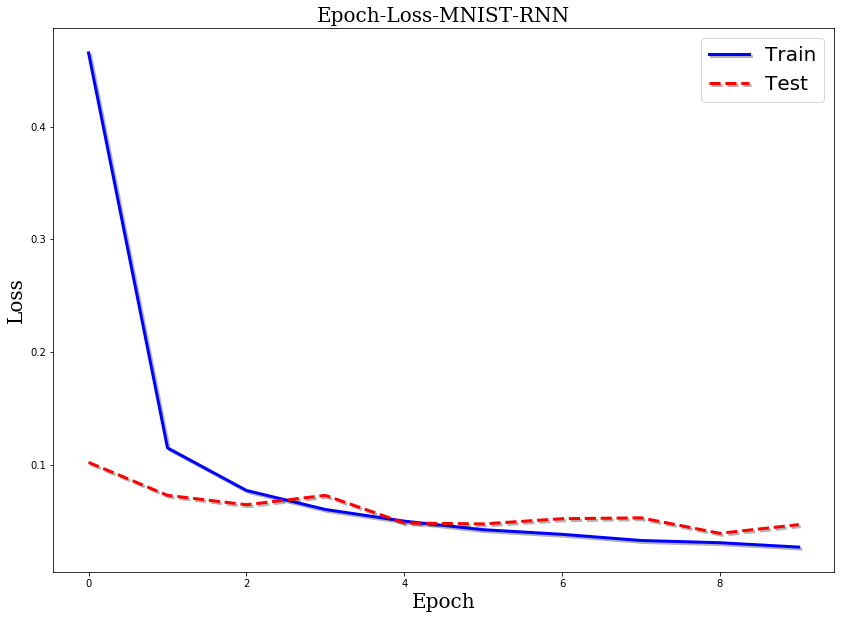

In [12]:
# 損失グラフの描画　% matplotlib inline
plt.figure(figsize=(14,10))

plt.plot(history.history['loss'], 
         color='b', 
         linestyle='-', 
         linewidth=3, 
         path_effects=[path_effects.SimpleLineShadow(),
                       path_effects.Normal()])
plt.plot(history.history['val_loss'], 
         color='r', 
         linestyle='--',
         linewidth=3,
         path_effects=[path_effects.SimpleLineShadow(),
                       path_effects.Normal()])

plt.title('Epoch-Loss-MNIST-RNN',fontsize=25,font_properties=fp2)
plt.ylabel('Loss',fontsize=20,font_properties=fp2)
plt.xlabel('Epoch',fontsize=20,font_properties=fp2)
plt.legend(['Train', 'Test'], loc='best', fontsize=20)
plt.savefig('Epoch-Loss-MNIST-RNN.pdf')
plt.show()

In [13]:
# 未知データのクラスの予測
pred_classes = np.argmax(pred, axis=1)
print(pred_classes)


[7 2 1 ... 4 5 6]


In [14]:
# 混合行列の描画関数の定義
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import pylab
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(12,9))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize=25)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=15)
    # plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45,fontsize=15)
    plt.yticks(tick_marks, classes,fontsize=15)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center", fontsize=15,
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize=20)
    plt.xlabel('Predicted label',fontsize=20)

Confusion matrix, without normalization
[[ 973    0    2    0    0    1    8    0    4    0]
 [   0 1131    0    0    0    1    2    3    0    0]
 [   0    1 1018    6    0    1    1    3    2    1]
 [   0    2    4  993    0    7    0    1    1    1]
 [   4    0    1    0  978    0    6    1    1    9]
 [   0    0    0    6    0  877    0    0    1    0]
 [   0    0    0    0    0    1  939    0    0    0]
 [   2    1    6    3    0    2    0 1018    3    4]
 [   1    0    1    1    0    1    2    0  960    4]
 [   0    0    0    1    4    1    0    2    2  990]]


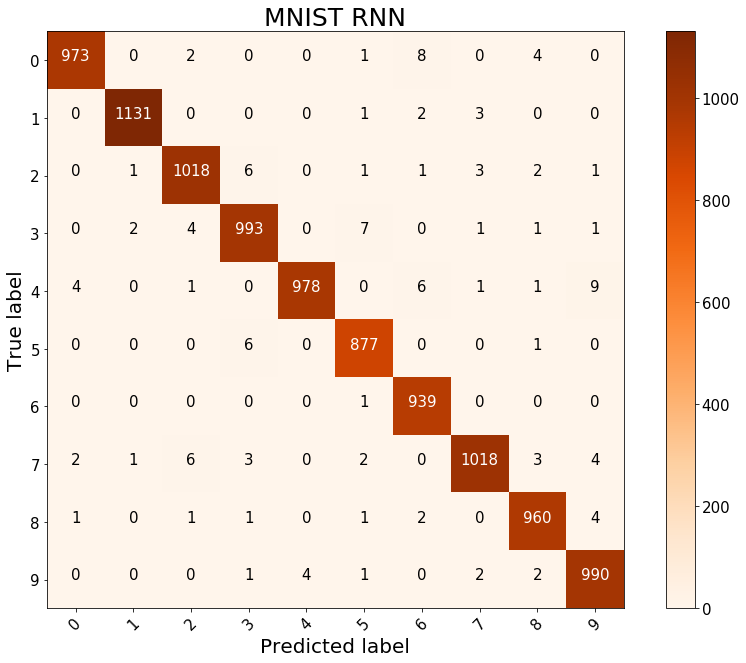

In [15]:
from sklearn.metrics import confusion_matrix # 混合行列
actual = np.argmax(y_test, axis=1)
cm = confusion_matrix(pred_classes, actual)

classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
plot_confusion_matrix(cm, classes=classes, title='MNIST RNN')
plt.show()


In [16]:
count = 0
total = actual.shape[0]
for i in range(total):
    if actual[i] == pred_classes[i]:
        count += 1
accuracy = float(count)/total
print("分類精度 = ",accuracy)

分類精度 =  0.9877
